# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *

In [2]:
import os
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomRotation((-7.0, 7.0), fill=(0,)),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])


train_transforms = transforms.Compose([
                                      #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-15., 15.), fill=0),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])



# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,616
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             250
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,456
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13     

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11644050478935242 Batch_id=468 Accuracy=88.36: 100% 469/469 [00:04<00:00, 116.87it/s]



Test set: Average loss: 0.0660, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.07541137933731079 Batch_id=468 Accuracy=96.84: 100% 469/469 [00:04<00:00, 113.46it/s] 



Test set: Average loss: 0.0443, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.1015666201710701 Batch_id=468 Accuracy=97.34: 100% 469/469 [00:04<00:00, 115.38it/s]  



Test set: Average loss: 0.0366, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.09394055604934692 Batch_id=468 Accuracy=97.62: 100% 469/469 [00:04<00:00, 104.49it/s] 



Test set: Average loss: 0.0356, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.023384856060147285 Batch_id=468 Accuracy=97.73: 100% 469/469 [00:04<00:00, 116.00it/s]



Test set: Average loss: 0.0329, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.08383197337388992 Batch_id=468 Accuracy=97.87: 100% 469/469 [00:04<00:00, 110.89it/s] 



Test set: Average loss: 0.0356, Accuracy: 9882/10000 (98.82%)

EPOCH: 6


Loss=0.08668600767850876 Batch_id=468 Accuracy=98.14: 100% 469/469 [00:04<00:00, 108.44it/s] 



Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.011691652238368988 Batch_id=468 Accuracy=98.38: 100% 469/469 [00:04<00:00, 113.48it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.09031051397323608 Batch_id=468 Accuracy=98.39: 100% 469/469 [00:04<00:00, 114.69it/s] 



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.03063933737576008 Batch_id=468 Accuracy=98.42: 100% 469/469 [00:04<00:00, 113.07it/s]  



Test set: Average loss: 0.0243, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.050667230039834976 Batch_id=468 Accuracy=98.31: 100% 469/469 [00:04<00:00, 110.35it/s]



Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.03242512047290802 Batch_id=468 Accuracy=98.34: 100% 469/469 [00:04<00:00, 109.66it/s] 



Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.0308601763099432 Batch_id=468 Accuracy=98.43: 100% 469/469 [00:04<00:00, 116.13it/s]  



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.07113080471754074 Batch_id=468 Accuracy=98.41: 100% 469/469 [00:04<00:00, 112.27it/s] 



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.016130628064274788 Batch_id=468 Accuracy=98.42: 100% 469/469 [00:04<00:00, 110.07it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

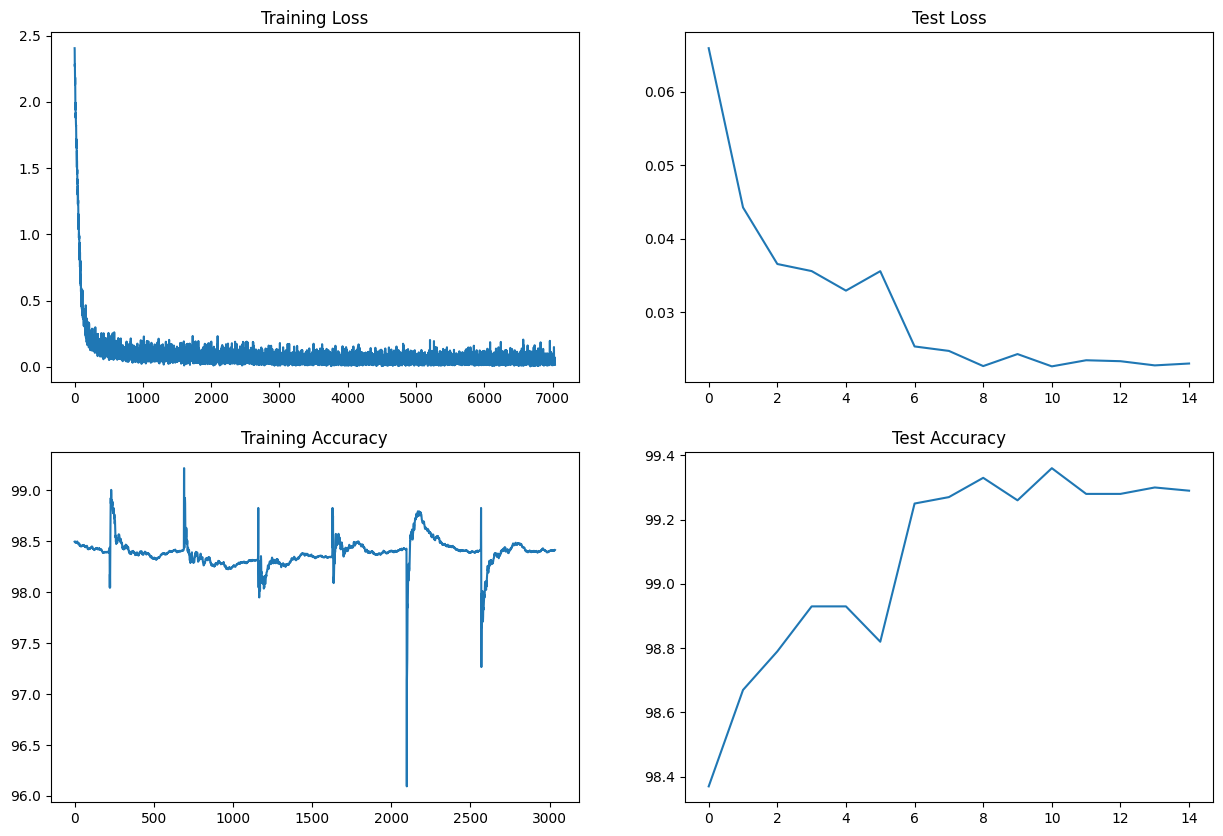

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")